# Machine Learning HW3
### Ze Yang (zey@andrew.cmu.edu)

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import rpy2
%reload_ext rpy2.ipython
import time
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, \
    roc_curve, confusion_matrix, auc, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, \
    LassoCV, RidgeCV, RidgeClassifierCV, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from pygam import LogisticGAM
from pygam.utils import generate_X_grid
from copy import copy
from progressbar import ProgressBar
from tabulate import tabulate

# 1. Clustering DJIA Data
## 1-(a) Plot of Log Returns

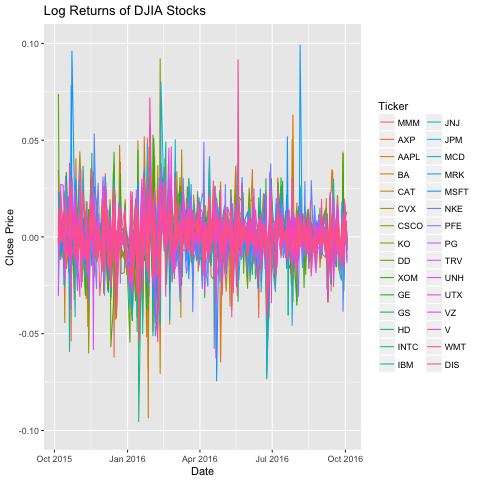

In [3]:
%%R
library(ggplot2)
library(reshape2)
load('djia_data.RData')
log.ret = sapply(
    djia_close[1:30], function(x) diff(log(x), lag=1))
log.ret = as.data.frame(log.ret)
log.ret$date = djia_close$date[2:nrow(djia_close)]
log.ret.melt = melt(log.ret, id=c('date'))
ggplot(data = log.ret.melt, aes(x=date, y=value)) + geom_line(
    aes(colour=variable)) + labs(
    x="Date", y="Close Price", colour="Ticker", 
    title='Log Returns of DJIA Stocks') + ylim(-0.1, 0.1)

## 1-(b) Distance & Hclust

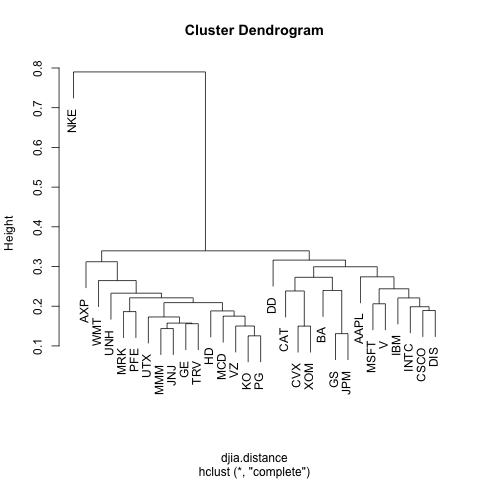

In [7]:
%%R
resolve_groups = function(groups, djia_info){
  k = length(unique(groups))
  industry = vector('list',k)
  symbol = vector('list',k)
  company = vector('list',k)
  #Loop over each group
  for(i in 1:k){
    idx = which(djia_info$Symbol %in% names(groups)[which(groups==i)])
    industry[[i]] = as.character(djia_info$Industry[idx])
    symbol[[i]] = as.character(djia_info$Symbol[idx])
    company[[i]] = as.character(djia_info$Company[idx])
  }
  list(industry=industry, symbol=symbol, company=company)
}

djia.distance = dist(t(as.matrix(log.ret[1:30])))
hclust.out = hclust(djia.distance, 'complete')
plot(hclust.out)

- The weird thing: NIKE is very high-located in the tree, as opposed to all other stocks. This means that NIKE's log return is very dissimilar from all other stocks when measured with Euclidean distance.

## 1-(c) Selecting 3 Groups

In [8]:
%%R
groups = cutree(hclust.out, 3)
resolve_groups(groups, djia)

$industry
$industry[[1]]
 [1] "Conglomerate"              "Consumer finance"         
 [3] "Beverages"                 "Conglomerate"             
 [5] "Home improvement retailer" "Pharmaceuticals"          
 [7] "Fast food"                 "Pharmaceuticals"          
 [9] "Pharmaceuticals"           "Consumer goods"           
[11] "Insurance"                 "Managed health care"      
[13] "Conglomerate"              "Telecommunication"        
[15] "Retail"                   

$industry[[2]]
 [1] "Consumer electronics"              "Aerospace and defense"            
 [3] "Construction and mining equipment" "Oil & gas"                        
 [5] "Computer networking"               "Chemical industry"                
 [7] "Oil & gas"                         "Banking"                          
 [9] "Semiconductors"                    "Computers and technology"         
[11] "Banking"                           "Consumer electronics"             
[13] "Consumer banking"              

- The first group contains medicines, food, and retail industries.
- The second group contains finance, high-tech, and energy industries.
- The third group only contains Nike.
- Possible story behind the groups: the industries represented by the 1st group are more traditional then the 2nd, so the stock returns are possibly less volatile. The industries represented by the 2nd group are modern, so they possibly have more volatile and higher (on average) returns.

## 1-(d) Single Method

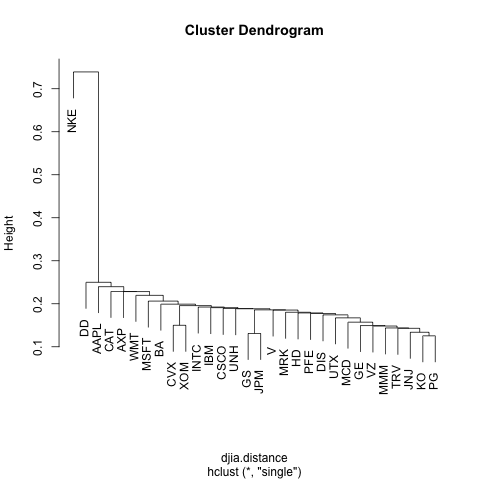

In [11]:
%%R
hclust.out.2 = hclust(djia.distance, 'single')
plot(hclust.out.2)

- The tree produced by `single` method are not as nice as the complete linkage tree. The distinction among groups are not so obvious.

## 1-(e) One-Correlation Distance

 MMM  AXP AAPL   BA  CAT  CVX CSCO   KO   DD  XOM   GE   GS   HD INTC  IBM  JNJ 
   1    2    3    3    3    3    3    1    3    3    3    3    1    3    3    1 
 JPM  MCD  MRK MSFT  NKE  PFE   PG  TRV  UNH  UTX   VZ    V  WMT  DIS 
   3    1    2    3    4    2    1    3    2    3    1    3    1    3 
$industry
$industry[[1]]
[1] "Conglomerate"              "Beverages"                
[3] "Home improvement retailer" "Pharmaceuticals"          
[5] "Fast food"                 "Consumer goods"           
[7] "Telecommunication"         "Retail"                   

$industry[[2]]
[1] "Consumer finance"    "Pharmaceuticals"     "Pharmaceuticals"    
[4] "Managed health care"

$industry[[3]]
 [1] "Consumer electronics"              "Aerospace and defense"            
 [3] "Construction and mining equipment" "Oil & gas"                        
 [5] "Computer networking"               "Chemical industry"                
 [7] "Oil & gas"                         "Conglomerate"                 

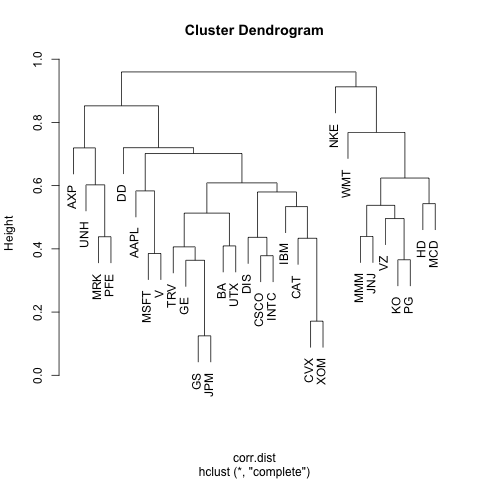

In [13]:
%%R
corr.dist = as.dist(1-cor(log.ret[1:30]))
hclust.out.3 = hclust(corr.dist, 'complete')
plot(hclust.out.3)
groups.3 = cutree(hclust.out.3, 4)
print(groups.3)
resolve_groups(groups.3, djia)

- The tree has a nicer shape than the one using Euclidean distance, namely, `NIKE` is brought closer to other companies.
- The first group contains food, and retail industries.
- The second group contains contains mainly medicine industry.
- The 4th group has only NIKE.

## 1-(f) Spearman Correlation

 MMM  AXP AAPL   BA  CAT  CVX CSCO   KO   DD  XOM   GE   GS   HD INTC  IBM  JNJ 
   1    2    2    2    3    3    2    1    3    3    2    2    4    2    2    1 
 JPM  MCD  MRK MSFT  NKE  PFE   PG  TRV  UNH  UTX   VZ    V  WMT  DIS 
   2    1    4    4    4    4    1    1    4    2    1    4    1    2 
$industry
$industry[[1]]
[1] "Conglomerate"      "Beverages"         "Pharmaceuticals"  
[4] "Fast food"         "Consumer goods"    "Insurance"        
[7] "Telecommunication" "Retail"           

$industry[[2]]
 [1] "Consumer finance"               "Consumer electronics"          
 [3] "Aerospace and defense"          "Computer networking"           
 [5] "Conglomerate"                   "Banking"                       
 [7] "Semiconductors"                 "Computers and technology"      
 [9] "Banking"                        "Conglomerate"                  
[11] "Broadcasting and entertainment"

$industry[[3]]
[1] "Construction and mining equipment" "Oil & gas"                       

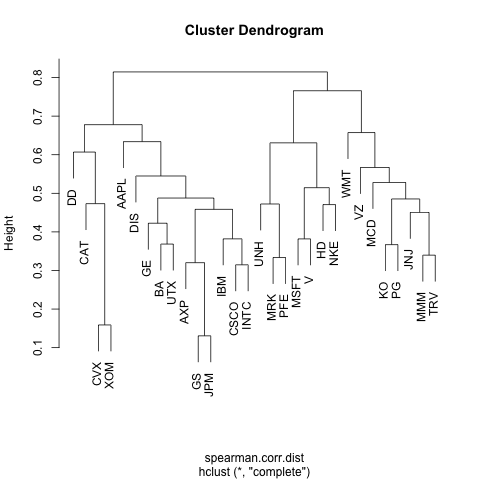

In [14]:
%%R
spearman.corr.dist = as.dist(1-cor(
    log.ret[1:30], method='spearman'))
hclust.out.4 = hclust(spearman.corr.dist, 'complete')
plot(hclust.out.4)
groups.4 = cutree(hclust.out.4, 4)
print(groups.4)
resolve_groups(groups.4, djia)

- The tree has a even better shape. In particular, `NIKE` is now brought down into the tree and is closer to other companies, and no group contains one single company any more.
- The reason is that: the log return of NIKE is not linearly correlated with its peers, but there exists some non-linear relationships, which was successfully captured by Spearman correlation.
- The grouping makes more sense: 
    - 1st group: food & retail.
    - 2nd group: finance & high-tech.
    - 3rd group: energy.
    - 4th group: others.

# 2. Hierarchical Clustering

## 2-(a) Scatter and Hierarchical Plot

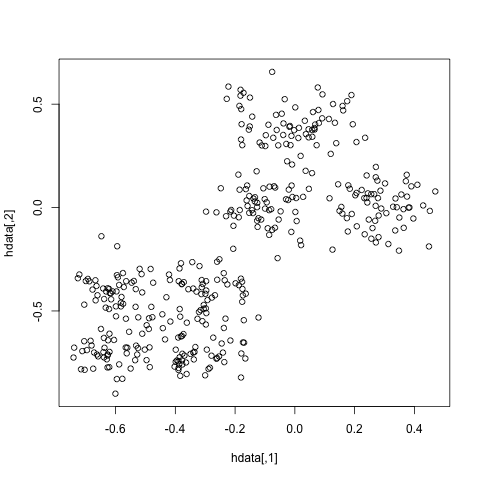

In [3]:
%%R
# scatter plot
load('hw3hierdata.RData')
plot(hdata)

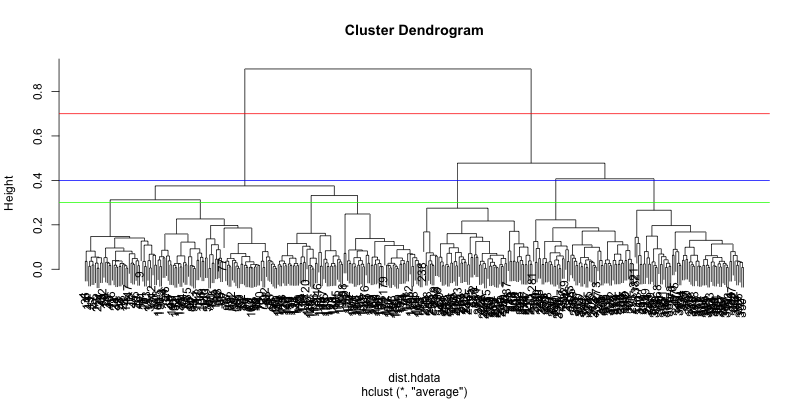

In [11]:
%%R -w 800 -h 400
# hierarchical plot
load('hw3hierdata.RData')
dist.hdata = dist(hdata)
hclust.out = hclust(dist.hdata, 'average')
plot(hclust.out)
abline(h=0.7, col='red')
abline(h=0.3, col='green')
abline(h=0.4, col='blue')

## 2-(b) Analysis of the Tree
- The two big groups are splited at height around 0.7 (red horizontal line).
- The left big group has 4 subgroups, which are splited at height$\approx0.3$ (green horizontal line). The right big group has 3 subgroups, which are splited at $h\approx 0.4$ (blue horizontal line)
- The subtrees corresponding to 7 small subgroups are those rooted at the green line ($h=0.3$). We can see the green line has exactly 7 intersections to the dendrogram.

## 2-(c) Slice the Tree

- See the plots below.
- The hierarchical clustering does correctly identify the groups and subgroups.
- The horizontal lines indicate the cuts. They are close to what we expected in part (b): the 2-groups cut is made at about h=0.7, the 4-subgroups cut is at $h\approx 0.4$, and the 7-subgroups cut at $h\approx 0.3$. These agree our manual cuts in part (b).

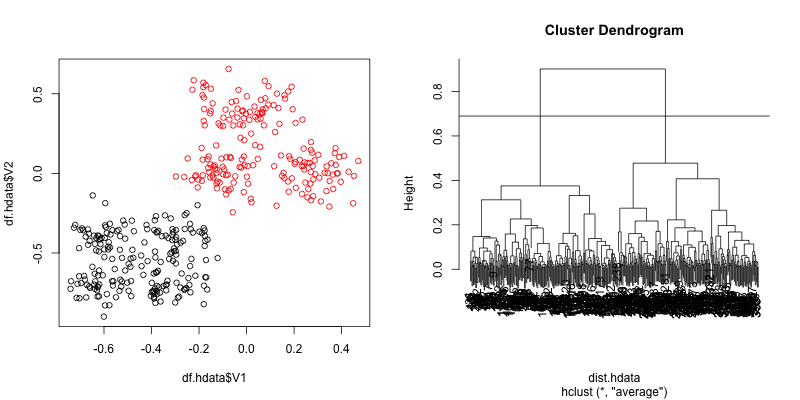

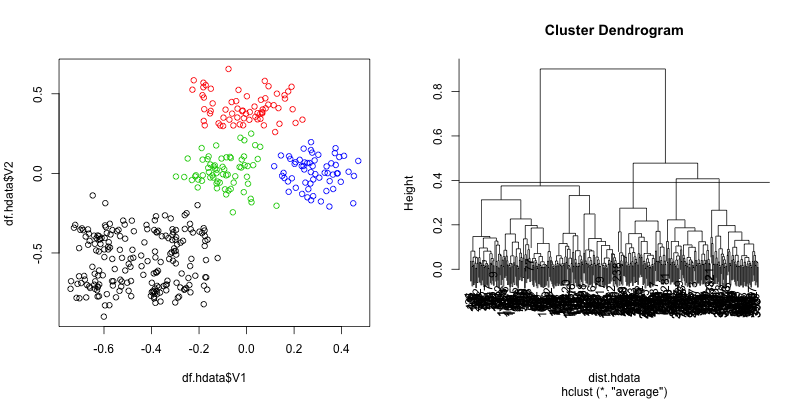

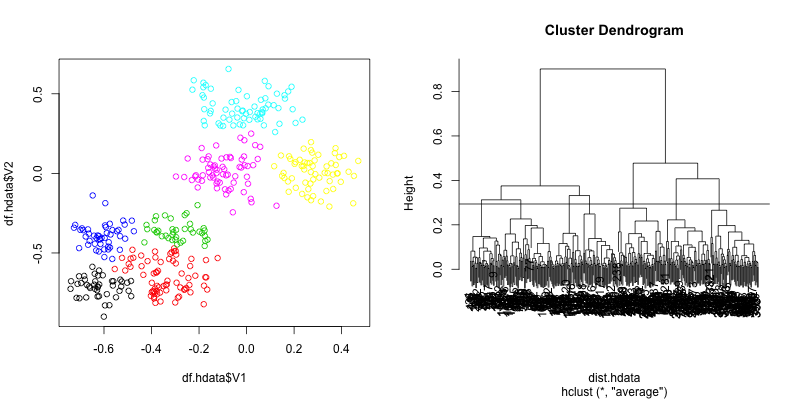

In [29]:
%%R -w 800 -h 400
df.hdata = as.data.frame(hdata)
for(k in c(2,4,7)) {
    group = cutree(hclust.out, k)
    df.hdata$group = group
    par(mfrow=c(1,2))
    plot(df.hdata$V1, df.hdata$V2, col=df.hdata$group)
    plot(hclust.out)
    abline(h=mean(rev(hclust.out$height)[(k-1):k]))
}

## 2-(d) Single Method

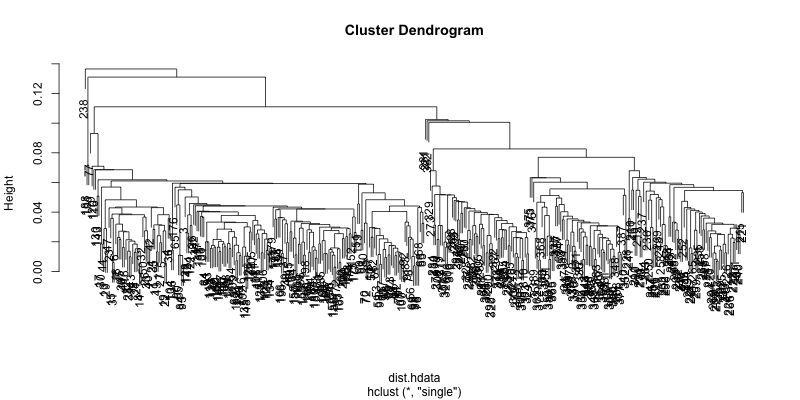

In [13]:
%%R -w 800 -h 400
hclust.out.single = hclust(dist.hdata, 'single')
plot(hclust.out.single)

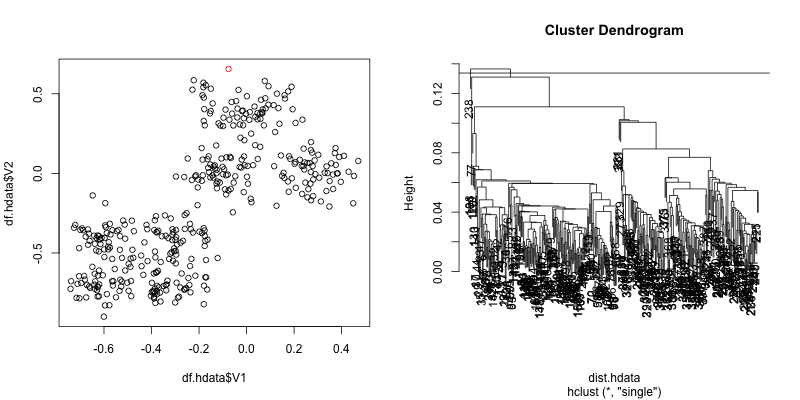

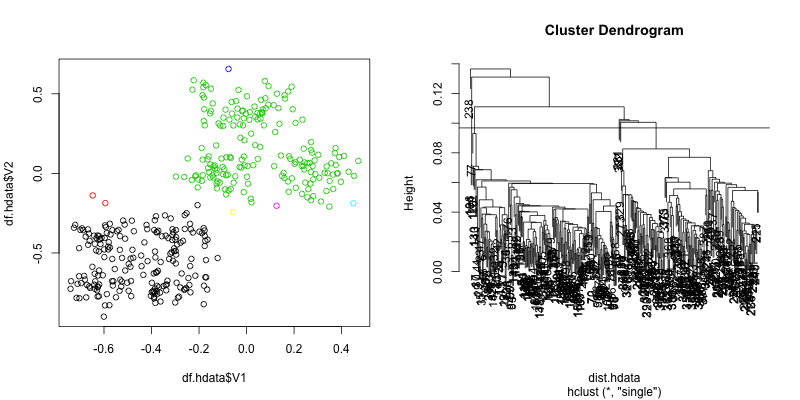

In [14]:
%%R -w 800 -h 400
df.hdata = as.data.frame(hdata)
for(k in c(2,7)) {
    group = cutree(hclust.out.single, k)
    df.hdata$group = group
    par(mfrow=c(1,2))
    plot(df.hdata$V1, df.hdata$V2, col=df.hdata$group)
    plot(hclust.out.single)
    abline(h=mean(rev(hclust.out.single$height)[(k-1):k]))
}

- For the single linkage tree, the groups are not as clear as before.
- For $k=2, k=7$, we failed to recover the same subgroups as we did in the last part, they look like poor cluster.
- Thing that has gone wrong: some groups (the black one in the $k=2$ case, and the green & black one in the $k=7$ case) are too spread-out, and other groups became very small, even singletons.
- The reason of this: single linkage suffers from chaining, which turns out to be severe in the problem. The subgroups require only 1 close pairs to be merged together. Consequently, in this problem, nearly all points are merged into one (or two) big group(s) due to the sequential occurrence of that "1 close pair", as a result, the points are all chained together.

# 3. Single Linkage Wins

## 3-(a) Plot the Data
- We are looking for a "two crescent moons" pattern.

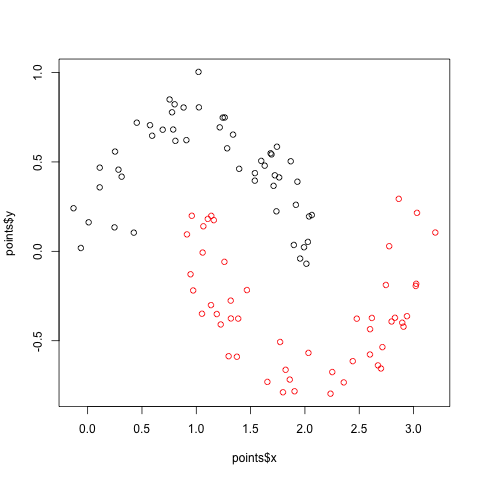

In [15]:
%%R
load('hw3single.RData')
plot(points$x, points$y, col=pieces)

## 3-(b) Kmeans

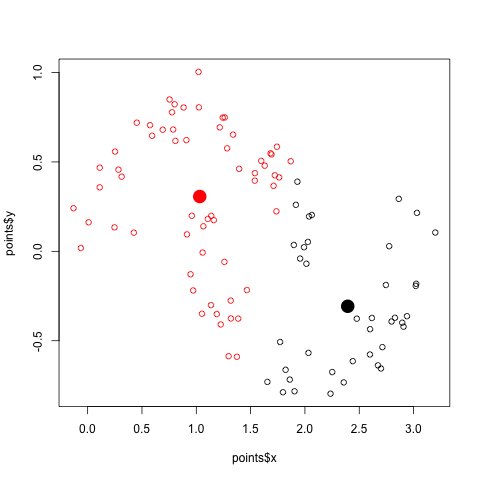

In [19]:
%%R
km.fit = kmeans(points, 2)
plot(points$x, points$y, col=km.fit$cluster)
points(km.fit$centers, col=c(1,2), pch=16, cex=2.5)

- Kmeans did poorly on recovering the clusters.
- It did poorly because its objective does not match to the problem's structure. The K-means cluster each pointed based on the closest class centroids. However, it's clear that the true cluster is not based on that. Points on the edge of the red cluster is closer to the centroid of black cluster than many of its own points.
- Kmeans' measure of dissimilarity is not appropriate.

## 3-(c) Complete Linkage

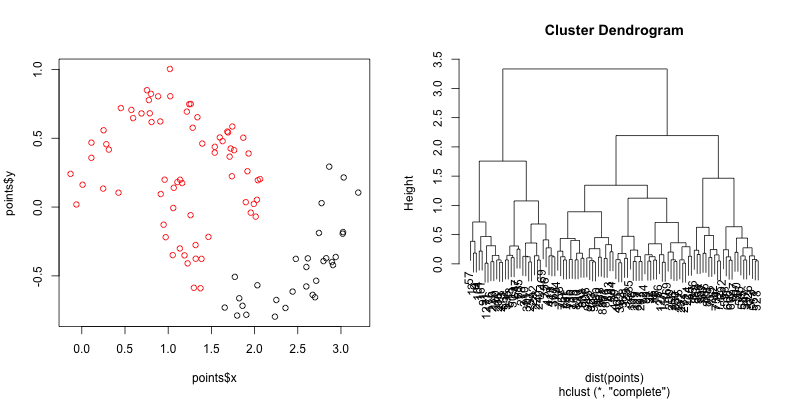

In [21]:
%%R -w 800 -h 400
hclust.fit1 = hclust(dist(points), 'complete')
group = cutree(hclust.fit1, 2)
par(mfrow=c(1,2))
plot(points$x, points$y, col=group)
plot(hclust.fit1)

- This still failed to capture the 2-crescent-moons pattern. The resulting clusters is similar to that of kmeans.
- Reason: the complete linkage method merges 2 subgroups by minimizing the distance between the furthest pair, but this still fail to capture the underlying pattern. The furthest distance of a pair of points in the black moon can be larger than the distance between many red points and its furthest partner in the black moon, but that does not mean that these red points should be merged into the black moon.
- Complete linkage's measure of dissimilarity is not appropriate.

## 3-(d) Single Linkage

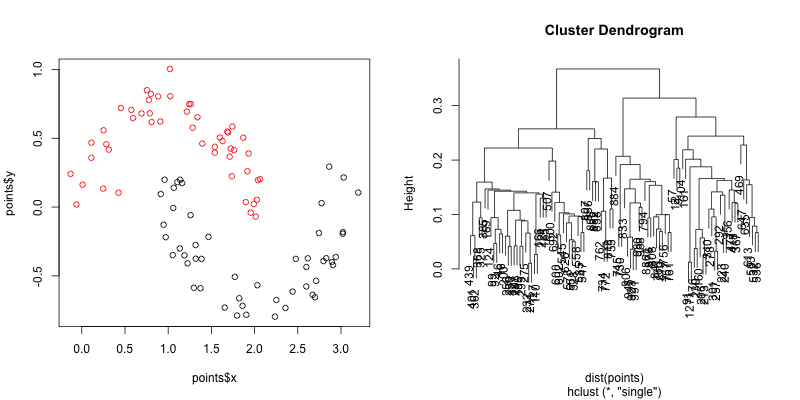

In [22]:
%%R -w 800 -h 400
hclust.fit2 = hclust(dist(points), 'single')
group = cutree(hclust.fit2, 2)
par(mfrow=c(1,2))
plot(points$x, points$y, col=group)
plot(hclust.fit1)

- The single linkage does very well, far better than the other two method.
- This is the case because chaining is exactly what we are looking for in this problem. A crescent moon looks just like a chain, rather than a cloud in other problems. So the ground truth clusters are based upon chaining patterns, which is what the single linkage method tends to do.

# 4. Digits Clustering

[1] 4
[1] 1
[1] 0


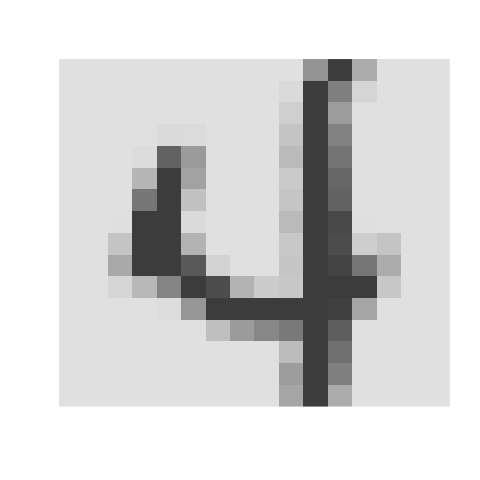

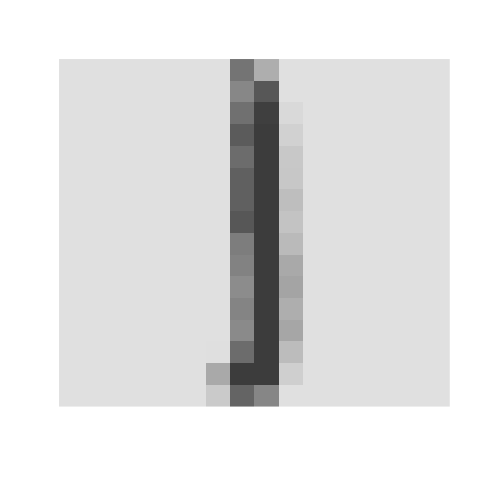

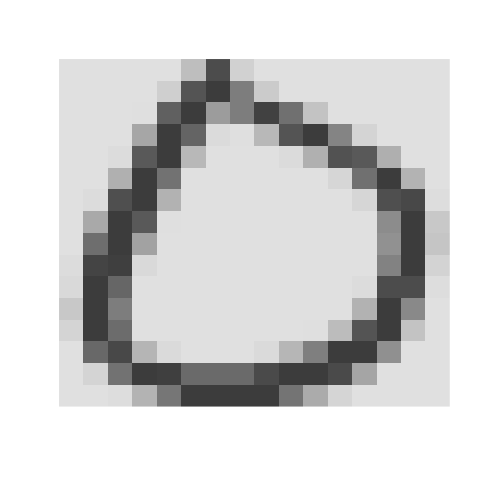

In [29]:
%%R
plot.digit = function(x,zlim=c(-1,1)) {
  x = as.matrix(x)
  cols = gray.colors(100)[100:1]
  image(matrix(x,nrow=16)[,16:1],col=cols,
        zlim=zlim,axes=FALSE)  
}

X = read.csv('x_014_tr.csv', header=FALSE)
y = read.csv('y_014_tr.csv', header=FALSE)
y = as.vector(y$V1)

for (i in c(1,2,3)) {
    plot.digit(X[i,])
    print(y[i])   
}

## 4-(a) Complete Linkage: Euclidean Distance

In [30]:
%%R
X.dist = dist(X)
hclust.fit = hclust(X.dist, 'complete')
group.3 = cutree(hclust.fit, 3)
xtabs(~group.3+y)

       y
group.3    0    1    4
      1  373    0   95
      2  214 1005  555
      3  607    0    2


- The complete linkage did well on separating '0', the first and thrid clusters contain mostly zeros.
- But it does poorly on '1' and '4'. The second cluster is mixing all '1' and most of the '4'.

In [31]:
%%R
group.6 = cutree(hclust.fit, 6)
xtabs(~group.6+y)

       y
group.6    0    1    4
      1   18    0   94
      2    0 1005  532
      3  607    0    2
      4  355    0    1
      5  211    0   23
      6    3    0    0


- We change the number of clusters to 6. 
- Clearly, the poor performance of complete linkage is not due to the number of clusters.
- 3rd-6th cluster captures almost all '0', and nearly no other digits
- But the 2nd cluster is still mixing all '1' and most of the '4'.

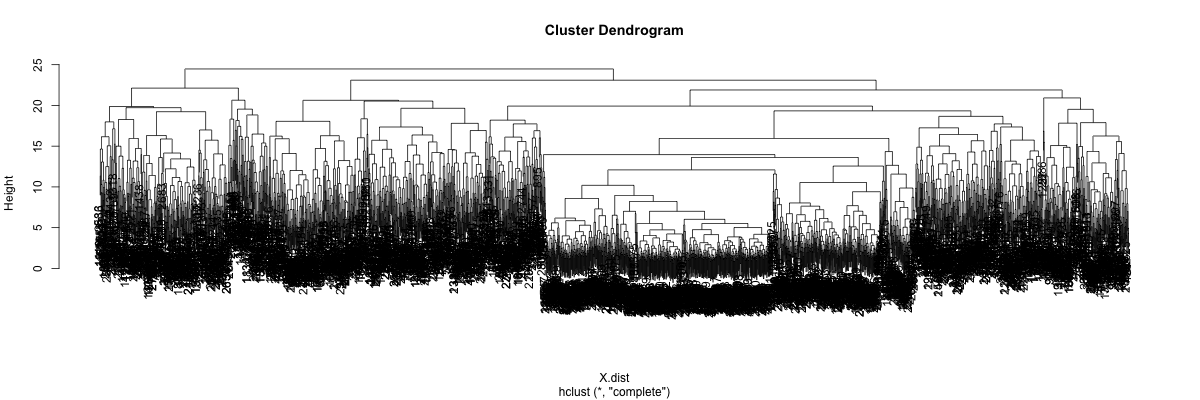

In [33]:
%%R -w 1200 -h 400
plot(hclust.fit)

## 4-(b) Tangent Distances

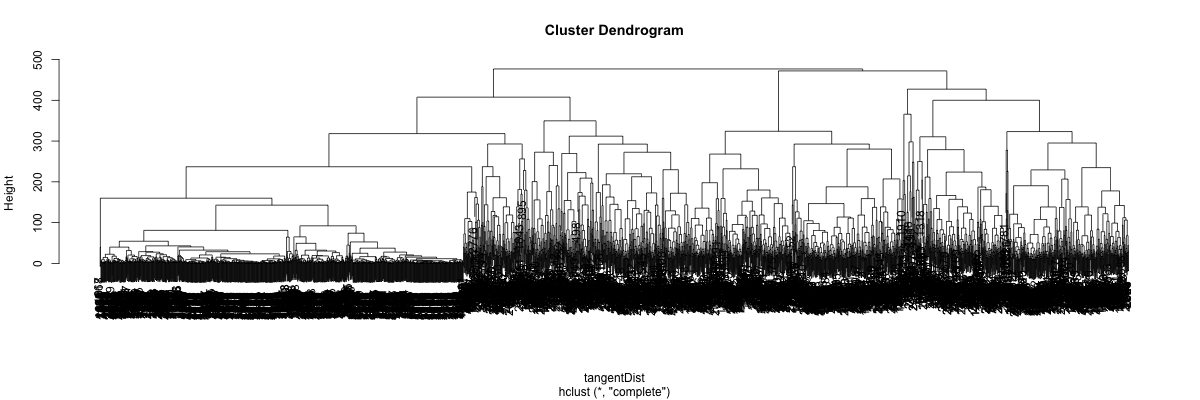

In [35]:
%%R -w 1200 -h 400
load('tangent_distances.RData')
hclust.tgt = hclust(tangentDist, 'complete')
plot(hclust.tgt)

In [41]:
%%R
group.3 = cutree(hclust.tgt, 3)
print(xtabs(~group.3+y))

       y
group.3    0    1    4
      1    0 1005  631
      2  589    0    0
      3  605    0   21


In [42]:
%%R
group.6 = cutree(hclust.tgt, 6)
print(xtabs(~group.6+y))

       y
group.6    0    1    4
      1    0    0  441
      2    0 1005  190
      3  589    0    0
      4  341    0    0
      5  250    0    1
      6   14    0   20


- 3 clusters seem to be not enough, it's still mixing '1' and '4', but note that all zeros can be picked out now, there's still improvement.
- 6 clusters will give a much better improvement. 3rd-5th clusters are picking almost all '0'; the 1st cluster picks most of the '4'; the 2nd cluster contains all '1', and only a small portion of '4'.

## 4-(c) Prototype Clustering

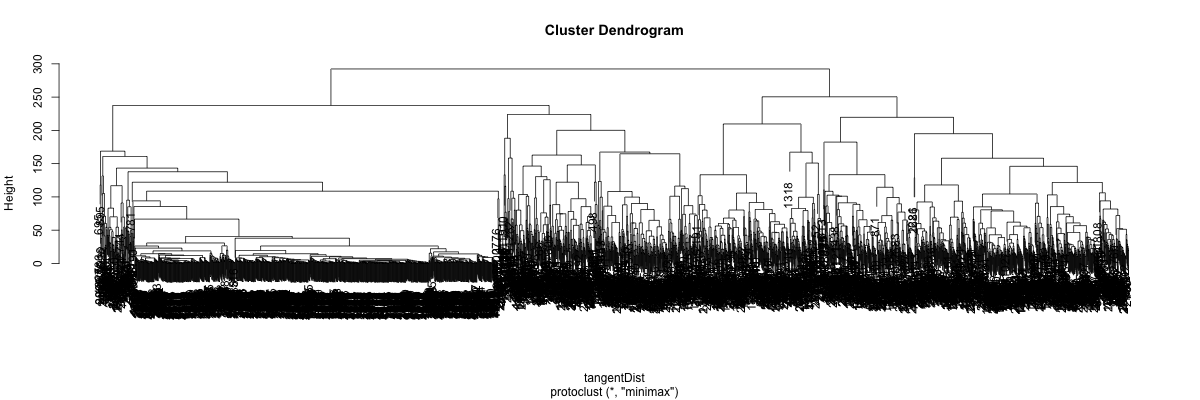

In [43]:
%%R -w 1200 -h 400
library(protoclust)
proto.fit = protoclust(tangentDist)
plot(proto.fit)

In [45]:
%%R
group.3 = protocut(proto.fit, 3)
print(xtabs(~group.3$cl+y))

          y
group.3$cl    0    1    4
         1    1 1005  651
         2  347    0    1
         3  846    0    0


In [46]:
%%R
group.6 = protocut(proto.fit, 6)
print(xtabs(~group.6$cl+y))

          y
group.6$cl    0    1    4
         1    0    0  505
         2    1 1005  113
         3  347    0    1
         4  595    0    0
         5    0    0   33
         6  251    0    0


- 3 clusters are still not enough.
- 6 clusters do better than the `hclust`. In particular:
    - Only one '0' is mixed with other digits. 
    - Only 113 '4' is now mixed with '1', improved from 190.

## 4-(d) Cluster Center Image

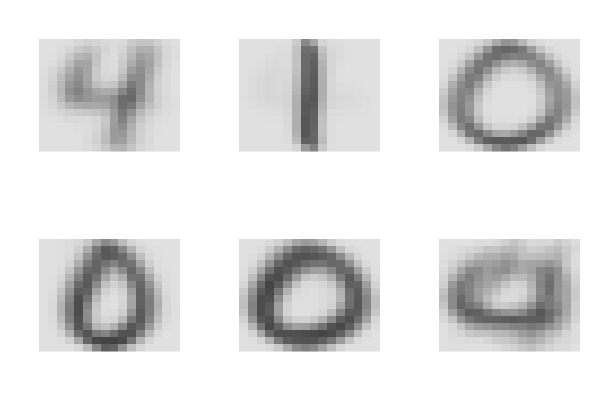

In [49]:
%%R -w 600 -h 400
# complete linkage cluster average digits
group.6.hclust = cutree(hclust.tgt, 6)
par(mfrow=c(2,3))
for(i in 1:6) {
    avg = colMeans(X[group.6.hclust==i,])
    plot.digit(avg)
}

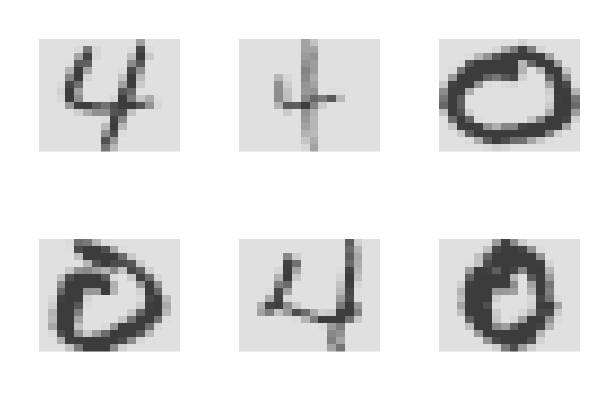

In [52]:
%%R -w 600 -h 400
# minimax cluster representative digits
group.6.minimax = protocut(proto.fit, 6)
minimax.center = group.6.minimax$protos
par(mfrow=c(2,3))
for(i in minimax.center) {
    plot.digit(X[i,])
}

I would say both have pros/cons in terms of interpretability.
- The representative digits of minimax clustering are actual data points, that's a good thing. However, the representative of the second cluster looks like a strange '4', while we know that the second group is in fact picking up all '1' and a small portion of '4'. So it might cause some confusion.
- The average image of complete linkage clustering are not true data points, so they appears to be more blurry. In particular, the image of the last cluster does not make sense because it's simply mixing a small amount of '4' and '0' that don't fit into any other clusters. The second cluster, however, does look like a '1'.

In general, I think the representative image of minimax clustering is easier to understand, except that for the big clusters (like the 2nd above), only one data point as representative may not be enough. One still need to look at the contingency table.